# Ignore the code, scroll down to 2

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as snd
import scipy.signal as ss
from scipy.spatial.transform import Rotation

In [2]:
def hcp_peaks(m, a):
    def hkl(m):
        # hcp auswahlregel
        def leven(x):
            # l muss grade sein
            return x[2] % 2 == 0

        def h2k(x):
            # oder h+2k ungleich 3n
            return not (x[0] + 2 * x[1]) % 3 == 0

        hkls = itertools.product(range(-m, m + 1), repeat=3)
        return filter(lambda x: leven(x) or h2k(x), hkls)

    c = 1.66 * a
    m = 4  # highest order

    # hcp basis
    b1 = (2 * np.pi / a) * np.array((2 / np.sqrt(3), 0, 0))
    b2 = (2 * np.pi / a) * np.array((1 / np.sqrt(3), 1, 0))
    b3 = (2 * np.pi / c) * np.array((0, 0, 1))
    basis = np.stack((b1, b2, b3))

    peaks = list(hkl(m)) @ basis
    return peaks[np.linalg.norm(peaks, axis=1) <= m * max(np.linalg.norm(basis, axis=1))]  # cut spherical

In [3]:
def cart2pol(img, order=1):
    o = np.array(img.shape[:2]) / 2 - 0.5
    r = (np.array(img.shape[:2]) ** 2).sum() ** 0.5 / 2
    output = np.zeros((int(round(r)), int(round(r * 2 * np.pi))))
    out_h, out_w = output.shape
    rs = np.linspace(0, r, out_h)
    ts = np.linspace(0, np.pi * 2, out_w)
    xs = rs[:, None] * np.cos(ts) + o[1]
    ys = rs[:, None] * np.sin(ts) + o[0]
    snd.map_coordinates(img, (ys, xs), order=order, output=output)
    return output


def pol2cart(img, order=1):
    r = img.shape[0]
    output = np.zeros((r * 2, r * 2), dtype=img.dtype)
    o = np.array(output.shape) / 2 - 0.5
    out_h, out_w = output.shape
    ys, xs = np.mgrid[:out_h, :out_w] - o[:, None, None]
    rs = (ys ** 2 + xs ** 2) ** 0.5
    ts = np.arccos(xs / rs)
    ts[ys < 0] = np.pi * 2 - ts[ys < 0]
    ts *= (img.shape[1] - 1) / (np.pi * 2)
    snd.map_coordinates(img, (rs, ts), order=order, output=output)
    return output

In [4]:
peaks = hcp_peaks(3, 1 / 10)
Nimg = 50
noiselevel = 0.5 
peaksize = 2

#creating images
imgs = []
for i in range(Nimg):
    # create randomly oriented image
    rotangle = np.random.uniform(2 * np.pi)
    img = np.zeros((512, 512))
    rotpeaks = Rotation.from_rotvec(np.array((0, 0, rotangle))).apply(peaks)
    pixel = (rotpeaks[:, :2] + np.array(img.shape) / 2).astype(int)
    pixel = pixel[np.all(pixel >= 0, 1) & np.all(pixel < img.shape, 1)]
    img[tuple(pixel.T)] += 1
    img = snd.gaussian_filter(img, peaksize)
    img /= img.max()
    img += noiselevel* np.random.randn(*img.shape)
    imgs.append(img)

# create non-rotated ground truth
img = np.zeros((512, 512))
pixel = (peaks[:, :2] + np.array(img.shape) / 2).astype(int)
pixel = pixel[np.all(pixel >= 0, 1) & np.all(pixel < img.shape, 1)]
img[tuple(pixel.T)] += 1
img = snd.gaussian_filter(img, 2)
img /= img.max()
gt = np.copy(img)


# Consider randomly in the plane oriented hcp supperlattice

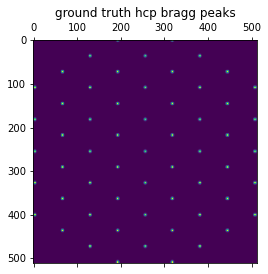

In [5]:
plt.matshow(gt)
plt.title('ground truth hcp bragg peaks');

### The invididual images are noisy and randomly rotated

individual images:


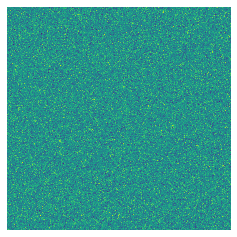

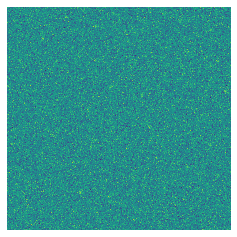

etc...
for 50 images total


In [6]:
print('individual images:')
for img in imgs[:2]:
    plt.matshow(img)
    plt.axis('off')
    plt.show()

print(f'etc...\nfor {Nimg} images total')

### The mean gives noisy rings..

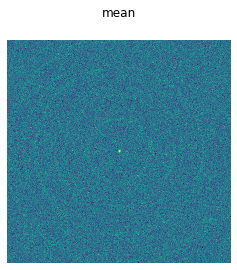

In [7]:
plt.matshow(np.mean(imgs, 0), vmax=0.5)
plt.title('mean')
plt.axis('off')
plt.show()

## The mean of the polar correlations gives peaks

<ipython-input-8-c60b14439b96>:9: RuntimeWarning: divide by zero encountered in true_divide
  res = (np.mean(correlations,0)/norm)
<ipython-input-8-c60b14439b96>:9: RuntimeWarning: invalid value encountered in true_divide
  res = (np.mean(correlations,0)/norm)


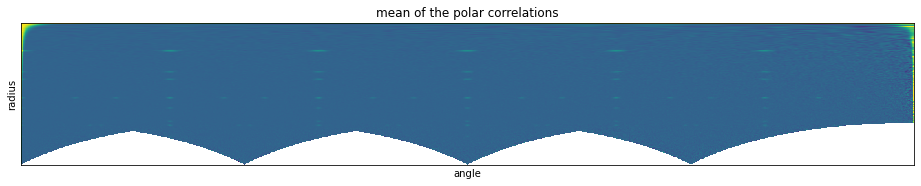

In [8]:
def polarcorrelate(img):
    #angular correlation for each radius
    polar = cart2pol(img)
    correlation = np.array([ss.correlate(p, p, method='fft') for p in np.array(polar)])
    return correlation

correlations = [polarcorrelate(img) for img in imgs]
norm = np.array(polarcorrelate(np.ones_like(gt)))
res = (np.mean(correlations,0)/norm)
res[norm<1] = np.nan


plt.matshow(res[:, res.shape[1] // 2 :],vmax=np.nanmax(res[5:,res.shape[1] // 2 + 20 : - 20]))
plt.ylabel('radius')
plt.xlabel('angle')
plt.xticks([])
plt.yticks([])
plt.title('mean of the polar correlations');

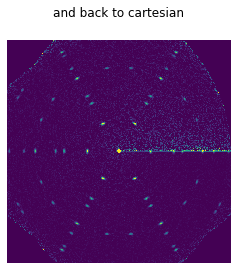

In [9]:
resC = pol2cart(np.nan_to_num(res[:,res.shape[1]//2:]))[106:-106, 106:-106]
plt.matshow(resC, vmax=.02, vmin=0)
plt.title('and back to cartesian')
plt.axis('off');

## As the correlation is done for each radius seperatly, they are all rotated to the same zero angle -- to get a familiar plot, we can correlate each radius with the first ring instead

<ipython-input-10-ef2f0853acd7>:2: RuntimeWarning: Mean of empty slice
  p = np.nanmean(res,1)


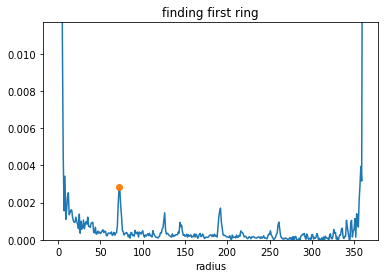

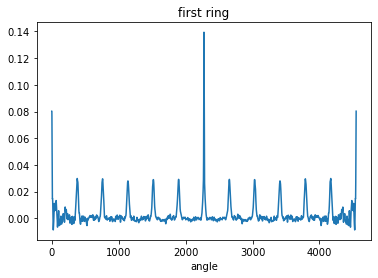

In [10]:
#finding index of first bragg ring
p = np.nanmean(res,1)
index = ss.find_peaks(p[20:],distance=100,prominence=.001)[0][0]+20

plt.plot(p)
plt.plot(index,p[index],'o')
plt.ylim(0,1.1*np.max(p[5:-10]))
plt.xlabel('radius')
plt.title('finding first ring')
plt.show()
plt.plot(res[index,:])
plt.xlabel('angle')
plt.title('first ring');

In [11]:
#now correlating with that ring

def indexedpolarcorrelate(img,index):
    polar = cart2pol(img)
    correlation = np.array([ss.correlate(p, polar[index,:], method='fft') for p in np.array(polar)])
    return correlation

correlationsI = [indexedpolarcorrelate(img,index) for img in imgs]
normI = indexedpolarcorrelate(np.ones_like(img),index)
resI = (np.mean(correlationsI,0)/normI)
resI[normI<1] = np.nan
resIC = pol2cart(np.nan_to_num(resI[:,resI.shape[1]//2:]))#[106:-106, 106:-106]


<ipython-input-11-fccecc5dfc17>:10: RuntimeWarning: divide by zero encountered in true_divide
  resI = (np.mean(correlationsI,0)/normI)
<ipython-input-11-fccecc5dfc17>:10: RuntimeWarning: invalid value encountered in true_divide
  resI = (np.mean(correlationsI,0)/normI)


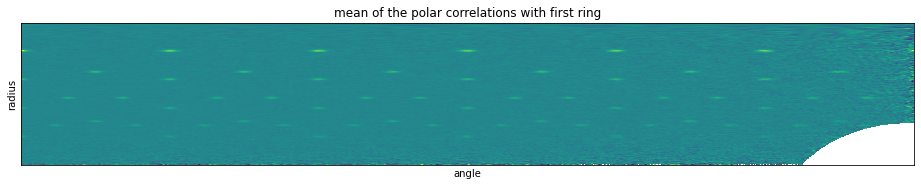

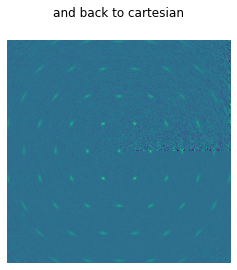

In [12]:
plt.matshow(resI[:, resI.shape[1] // 2 :],vmax=np.nanmax(resI[5:,resI.shape[1] // 2 + 20 : - 20]))
plt.ylabel('radius')
plt.xlabel('angle')
plt.xticks([])
plt.yticks([])
plt.title('mean of the polar correlations with first ring');

plt.matshow(resIC[106:-106, 106:-106],vmax=.05)
plt.title('and back to cartesian')
plt.axis('off');